In [1]:
import os
import sys
import git
import pathlib

import random

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use GPU
# Using GPU during inference has deterministic results (same as CPU)

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

from libs import utils, mnist32_cnn
from libs.constants import model_seeds

In [2]:
# Limit GPU growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# Prepare dataset
# Combine test and train images together into one dataset
DATASET_PATH = str(pathlib.Path(PROJ_ROOT_PATH / "datasets" / "mnist.npz" ))
(train_images, train_labels), (test_images, test_labels) = mnist.load_data(path=DATASET_PATH)
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0  

all_images =np.concatenate([train_images, test_images], axis=0)
all_labels =np.concatenate([train_labels, test_labels], axis=0)
all_images = np.expand_dims(all_images, axis=-1)

# resize the input shape , i.e. old shape: 28, new shape: 32
image_x_size = 32
image_y_size = 32
all_images = tf.image.resize(all_images, [image_x_size, image_y_size]) 

In [4]:
model_type = "mnist32-cnn_1024_256_64"
imnum = 128*40
images = all_images[-imnum:]

In [5]:
conv_out_list= []
pool_out_list= []
flat_out_list= []
fc_0_out_list= []
fc_1_out_list= []
fc_2_out_list= []
op_layer_out_list= []

In [6]:
for model_seed in model_seeds:
    # Get model
    model_instance = model_type + "-" + str(model_seed)
    dataset, model_arch, model_config, layer_widths, seed = utils.instancename2metadata(model_instance)
    model_meta_type, model_type, model_instance = utils.metadata2instancenames(dataset, model_arch, layer_widths, seed)

    model_folder = pathlib.Path(PROJ_ROOT_PATH / "models" / model_type)
    model_filename = model_instance + ".h5"
    model_file = pathlib.Path(model_folder/ model_filename)
    
    # Load model
    model = tf.keras.models.load_model(model_file)
    
    # Log output of each layer
    conv_out = model.layers[0](images)
    conv_out_list.append(conv_out)

    pool_out = model.layers[1](
                    model.layers[0](images))
    pool_out_list.append(pool_out)

    flat_out = model.layers[2](
                    model.layers[1](
                        model.layers[0](images)))
    flat_out_list.append(flat_out)

    fc_0_out = model.layers[3](
                    model.layers[2](
                        model.layers[1](
                            model.layers[0](images))))
    fc_0_out_list.append(fc_0_out)

    fc_1_out = model.layers[4](
                    model.layers[3](
                      model.layers[2](
                          model.layers[1](
                              model.layers[0](images)))))
    fc_1_out_list.append(fc_1_out)

    fc_2_out = model.layers[5](
                  model.layers[4](
                      model.layers[3](
                          model.layers[2](
                              model.layers[1](
                                  model.layers[0](images))))))
    fc_2_out_list.append(fc_2_out)

    op_layer_out = model.layers[6](
                      model.layers[5](
                          model.layers[4](
                              model.layers[3](
                                  model.layers[2](
                                      model.layers[1](
                                          model.layers[0](images)))))))
    op_layer_out_list.append(op_layer_out)

In [7]:
import matplotlib.pyplot as plt

In [8]:
# fig, ax = plt.subplots()

# vp = ax.violinplot(D, [2, 4, 6], widths=2,
#                    showmeans=False, showmedians=False, showextrema=False)

In [9]:
all_conv_out = np.array(conv_out_list).flatten()
all_pool_out = np.array(pool_out_list).flatten()
all_flat_out = np.array(flat_out_list).flatten()
all_fc_0_out = np.array(fc_0_out_list).flatten()
all_fc_1_out = np.array(fc_1_out_list).flatten()
all_fc_2_out = np.array(fc_2_out_list).flatten()
all_op_layer_out = np.array(op_layer_out_list).flatten()

In [10]:
data = [
        # all_conv_out,
        # all_pool_out,
        # all_flat_out,
        all_fc_0_out,
        all_fc_1_out,
        all_fc_2_out,
        all_op_layer_out,
       ]

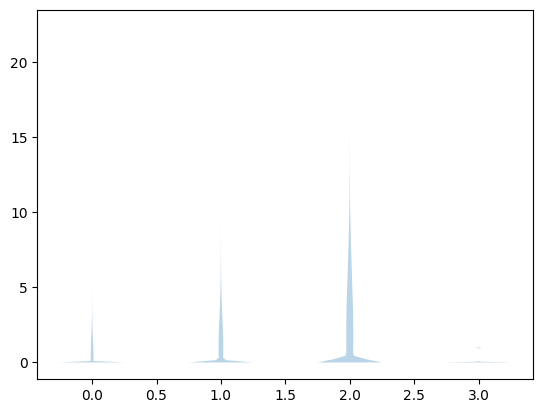

In [11]:
plt.violinplot(data,np.arange(len(data)),
              showmeans=False, showmedians=False, showextrema=False)
plt.show()

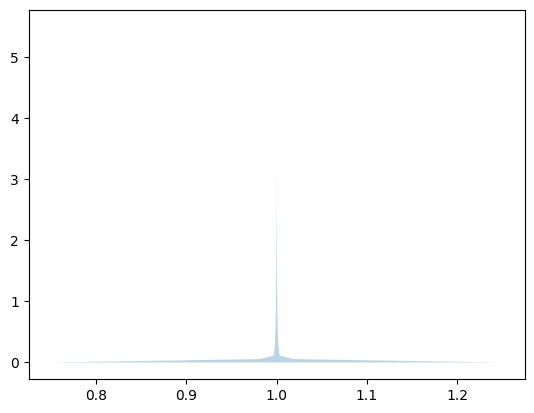

In [12]:
plt.violinplot(all_conv_out,
              showmeans=False, showmedians=False, showextrema=False)
plt.show()